In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext tensorboard
%tensorboard --logdir=../lightning_logs/

In [3]:
import json
import os
import pickle
from glob import glob

import bs4
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, CamembertModel, CamembertTokenizer, BertTokenizer

In [4]:
deputies_df = pd.read_pickle("../data/2017-2022/deputies.pkl")

In [5]:
groups = deputies_df.groupe_sigle.unique()
groups_to_int = dict(zip(groups, range(len(groups))))
int_to_groups = dict(zip(range(len(groups)), groups))

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
use_cuda

True

In [28]:
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

In [30]:
tokenize = lambda x: tokenizer(
    x, padding="max_length", max_length=256, truncation=True, return_tensors="pt"
)

decode_tokens = lambda x: tokenizer.decode(x)

In [38]:
files = glob("../data/2017-2022/interventions/*.json")
file_stats = [os.stat(file).st_size for file in files]
no_empty_files = [files[i] for i in range(len(files)) if file_stats[i] > 63]
slug_files = [file.split("/")[-1].split(".")[0] for file in no_empty_files]
file_dict = dict(zip(slug_files, no_empty_files))

In [34]:
tdf = pd.read_csv("../tsvs/ND13_interventions_QAG.tsv", sep="\t")

In [55]:
tdf = pd.read_csv("../tsvs/ND15_interventions_hemicycle_rich.tsv", sep="\t")

In [356]:
tdf.to_pickle("../data/2017-2022/raw_dataset.pkl")

In [247]:
from bs4 import BeautifulSoup

In [331]:
tdf_without_pres = tdf[
    (~tdf.fonction.isin(['président', 'présidente', "président, doyen d'âge"]))  # Enlève le président
    # (~tdf.titre.str.contains("article"))  # Enlève les interventions sur les articles
]

tdf_without_exclamations = tdf_without_pres[
    (~tdf_without_pres.titre.isna()) &  # Enlève les interventions sans titre (transitions, présidents, ...)
    (~tdf_without_pres.sexe.isna()) &  # Enlève les interventions sans sexe (groupe, interlocutions, non députés, ...)
    (tdf_without_pres.nb_mots > 7)  # Enlève les interventions trop courtes
]

intervention_count = tdf_without_exclamations.parlementaire.value_counts().rename("intervention_count").to_frame()
tdf_without_exclamations = tdf_without_exclamations.merge(intervention_count, left_on="parlementaire", right_index=True)

In [282]:
def process_intervention(row, max_len=256):
    if row["nb_mots"] > max_len:
        paragraphs = BeautifulSoup(row["intervention"]).find_all('p')
        return [_.getText() for _ in paragraphs]
    return BeautifulSoup(row["intervention"]).text

In [309]:
processed_tdf_intervention = tdf_without_exclamations.apply(process_intervention, axis=1)
tdf_intervention_processed = tdf_without_exclamations.assign(intervention=processed_tdf_intervention).explode("intervention")
tdf_intervention_processed = tdf_intervention_processed[tdf_intervention_processed.intervention.str.count(' ') > 3]
tdf_intervention_processed["nb_mots_approx"] = tdf_intervention_processed.intervention.str.count(' ') + 1

In [321]:
tdf_without_short = tdf_intervention_processed[tdf_intervention_processed["intervention_count"] > 10].reset_index(drop=True)

In [322]:
tdf_without_short.to_pickle("../data/2017-2022/clean_interventions_df.pkl")

In [7]:
tdf_without_short = pd.read_pickle("../data/2017-2022/clean_interventions_df.pkl")

In [8]:
by_seance = tdf_without_short.groupby(["seance_id", "parlementaire"]).agg(
    count=pd.NamedAgg(column="id", aggfunc="count")
)

In [4]:
clean_deputies_df = deputies_df[["nom", "date_naissance", "num_circo", "profession", "nb_mandats"]].copy()
clean_deputies_df["profession"].fillna("None", inplace=True)

NameError: name 'deputies_df' is not defined

In [11]:
simple_interventions = tdf_without_short[[
    "parlementaire",
    "parlementaire_groupe_acronyme",
    "seance_id",
    "date",
    "type",
    "titre",
    "titre_complet",
    "intervention"
]].rename(columns={
    "parlementaire": "nom",
    "parlementaire_groupe_acronyme": "groupe",
    "date": "date_seance",
})

In [12]:
grouped_df = simple_interventions.groupby(["seance_id", "date_seance", "nom", "groupe", "type", "titre", "titre_complet"]).agg(
    intervention=pd.NamedAgg(column="intervention", aggfunc=lambda group: " ".join(group))
).reset_index()

In [13]:
processed_df = grouped_df.merge(clean_deputies_df, left_on="nom", right_on="nom")

In [14]:
processed_df.to_pickle("../data/2017-2022/final_df.pkl")

In [4]:
processed_df = pd.read_pickle("../data/2017-2022/final_df.pkl")

In [5]:
sub_groups_dict = {
    'NI': 'Droite',
    'UAI': 'Droite',
    'LC': 'Droite',
    'LR': 'Droite',
    'LFI': 'Gauche',
    'NG': 'Gauche',
    'GDR': 'Gauche',
    'LREM': 'Centre',
    'MODEM': 'Centre'
}

sub_to_int = {
    "Gauche": 0,
    "Centre": 1,
    "Droite": 2
}

labels_dict = {
    group: sub_to_int[sub_groups_dict[group]] for group in sub_groups_dict
}

In [6]:
import torch
from torch.utils.data import Dataset
import numpy as np

tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

class SeanceDataset(Dataset):
    def __init__(
        self,
        tokenizer,
        df,
        labels_dict,
        group_var="groupe",
        intervention_var="intervention",
        titre_var="titre_complet",
        profession_var="profession",
        max_len_padding=512,
        max_len_padding_titre=64,
        max_len_padding_profession=16,
    ):
        # Parameters
        self.df = df
        self.labels_dict = labels_dict
        self.inverse_label_dict = {v: k for k, v in labels_dict.items()}
        self.group_var = group_var
        self.intervention_var = intervention_var
        self.titre_var = titre_var
        self.profession_var = profession_var
        self.max_len_padding = max_len_padding
        self.max_len_padding_titre = max_len_padding_titre
        self.max_len_padding_profession = max_len_padding_profession
        
        # Inputs and labels
        self.labels = [labels_dict[label] for label in df[group_var]]
        
        self.interventions = [tokenizer(
            text,
            padding="max_length",
            max_length=max_len_padding,
            truncation=True,
            return_tensors="pt"
        ) for text in df[intervention_var]]
        
        self.titres = [tokenizer(
            text,
            padding="max_length",
            max_length=max_len_padding_titre,
            truncation=True,
            return_tensors="pt"
        ) for text in df[titre_var]]
        
        self.professions = [tokenizer(
            text,
            padding="max_length",
            max_length=max_len_padding_profession,
            truncation=True,
            return_tensors="pt"
        ) for text in df[profession_var]]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_inputs(self, idx):
        return {
            "intervention": self.interventions[idx],
            "titre": self.titres[idx],
            "profession": self.professions[idx]
        }

    def __getitem__(self, idx):
        batch_x = self.get_batch_inputs(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_x, batch_y

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
def get_dataset(
    tokenizer,
    processed_df,
    labels_dict,
    group_var="groupe",
    intervention_var="intervention",
    titre_var="titre_complet",
    profession_var="profession",
    max_len_padding=512,
    max_len_padding_titre=64,
    max_len_padding_profession=16,
    test_frac=0.25,
    val_frac=0.2
):
    X, y = np.arange(len(processed_df)), processed_df["groupe"]
    test_frac = 0.25
    val_frac = 0.2

    idx_train, idx_test, y_train, y_test = train_test_split(X, y, test_size=test_frac, random_state=42, stratify=y)
    idx_train, idx_val, y_train, y_val = train_test_split(idx_train, y_train, test_size=val_frac, random_state=42, stratify=y_train)
    
    train_dataset = SeanceDataset(
        tokenizer,
        processed_df.iloc[idx_train],
        labels_dict,
        group_var=group_var,
        intervention_var=intervention_var,
        titre_var=titre_var,
        profession_var=profession_var,
        max_len_padding=max_len_padding,
        max_len_padding_titre=max_len_padding_titre,
        max_len_padding_profession=max_len_padding_profession,
    )

    val_dataset = SeanceDataset(
        tokenizer,
        processed_df.iloc[idx_val],
        labels_dict,
        group_var=group_var,
        intervention_var=intervention_var,
        titre_var=titre_var,
        profession_var=profession_var,
        max_len_padding=max_len_padding,
        max_len_padding_titre=max_len_padding_titre,
        max_len_padding_profession=max_len_padding_profession,
    )

    test_dataset = SeanceDataset(
        tokenizer,
        processed_df.iloc[idx_test],
        labels_dict,
        group_var=group_var,
        intervention_var=intervention_var,
        titre_var=titre_var,
        profession_var=profession_var,
        max_len_padding=max_len_padding,
        max_len_padding_titre=max_len_padding_titre,
        max_len_padding_profession=max_len_padding_profession,
    )
    
    return train_dataset, val_dataset, test_dataset

def get_dataloader(
    train_dataset,
    val_dataset,
    test_dataset,
    batch_size=32,
    num_workers=8,
):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)
    
    return train_dataloader, val_dataloader, test_dataloader

In [9]:
from torch import nn
from transformers import CamembertModel

class SeanceClassifier(nn.Module):
    def __init__(
        self,
        bert_model,
        num_classes,
        intervention_dim=256,
        titre_dim=128,
        profession_dim=64,
        bert_dim=768,
        dropout=0.1
    ):
        super(SeanceClassifier, self).__init__()
        
        # Parameters
        self.num_classes = num_classes
        self.intervention_dim = intervention_dim
        self.titre_dim = titre_dim
        self.profession_dim = profession_dim
        self.inter_dim = intervention_dim + titre_dim + profession_dim
        self.bert_dim = bert_dim
        self.dropout = dropout

        self.bert = bert_model
        
        self.intervention_linear = nn.Linear(bert_dim, intervention_dim)
        self.titre_linear = nn.Linear(bert_dim, titre_dim)
        self.profession_linear = nn.Linear(bert_dim, profession_dim)
        
        self.mlp = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.inter_dim, self.inter_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(self.inter_dim, self.inter_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(self.inter_dim, num_classes),
            nn.ReLU(),
        )

    def forward(self, intervention, titre, profession):
        # Embed interventions
        _, intervention_pooled_output = self.bert(
            input_ids=intervention['input_ids'].squeeze(1),
            attention_mask=intervention['attention_mask'].squeeze(1),
            return_dict=False
        )
        
        # Embed titre
        _, titre_pooled_output = self.bert(
            input_ids=titre['input_ids'].squeeze(1),
            attention_mask=titre['attention_mask'].squeeze(1),
            return_dict=False
        )
        
        # Embed profession
        _, profession_pooled_output = self.bert(
            input_ids=profession['input_ids'].squeeze(1),
            attention_mask=profession['attention_mask'].squeeze(1),
            return_dict=False
        )
        
        intervention_embeded = self.intervention_linear(intervention_pooled_output)
        titre_embeded = self.titre_linear(titre_pooled_output)
        profession_embeded = self.profession_linear(profession_pooled_output)
        
        # Concatenate the embeddings
        seance_repr = torch.cat([
            intervention_embeded, titre_embeded, profession_embeded
        ], dim=1)
    
        
        # MLP classifier layer
        final_output = self.mlp(seance_repr)

        return final_output

In [10]:
import pytorch_lightning as pl
from torch import optim, nn

class SeanceLitClassifier(pl.LightningModule):
    def __init__(
        self,
        processed_df,
        labels_dict,
        batch_size=32,
        num_workers=8,
        type_bert="camembert",
        freeze_bert=True,
        intervention_dim=256,
        titre_dim=128,
        profession_dim=64,
        bert_dim=768,
        dropout=0.1,
        lr=1e-3
    ):
        super().__init__()
        self.example_input_array = {
            "intervention": {"input_ids": torch.randint(0, 100, (32, 1, 512)), "attention_mask": torch.randint(0, 2, (32, 1, 512))},
            "titre": {"input_ids": torch.randint(0, 100, (32, 1, 64)), "attention_mask": torch.randint(0, 2, (32, 1, 64))},
            "profession": {"input_ids": torch.randint(0, 100, (32, 1, 16)), "attention_mask": torch.randint(0, 2, (32, 1, 16))}
        }
        
        # Parameters
        self.num_classes = len(np.unique(list(labels_dict.values())))
        self.processed_df = processed_df
        self.labels_dict = labels_dict
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.type_bert = type_bert
        self.freeze_bert = freeze_bert
        self.intervention_dim = intervention_dim
        self.titre_dim = titre_dim
        self.profession_dim = profession_dim
        self.bert_dim = bert_dim
        self.dropout = dropout
        self.lr = lr
        
        # Models
        if type_bert == "camembert":
            self.bert_model = CamembertModel.from_pretrained("camembert-base")
            self.tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
        else:
            self.bert_model = BertModel.from_pretrained("bert-base-multilingual-cased")
            self.tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
        
        if freeze_bert:
            for p in self.bert_model.parameters():
                p.requires_grad = False
        
        self.classifier = SeanceClassifier(
            bert_model=self.bert_model,
            num_classes=self.num_classes,
            intervention_dim=intervention_dim,
            titre_dim=titre_dim,
            profession_dim=profession_dim,
            bert_dim=bert_dim,
            dropout=dropout,
        )
        
        # Save the hyperparameters
        # See https://pytorch-lightning.readthedocs.io/en/latest/common/checkpointing_basic.html#save-a-checkpoint
        self.save_hyperparameters()
        
    def forward(self, intervention, titre, profession):
        return self.classifier(intervention, titre, profession)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        x_hat = self.forward(x["intervention"], x["titre"], x["profession"])
        loss = nn.CrossEntropyLoss()(x_hat, y)
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        # See more https://pytorch-lightning.readthedocs.io/en/latest/common/evaluation_basic.html
        x, y = batch
        x_hat = self.forward(x["intervention"], x["titre"], x["profession"])
        loss = nn.CrossEntropyLoss()(x_hat, y)
        # Logging to TensorBoard by default
        self.log("test_loss", loss)
        
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        x, y = batch
        x_hat = self.forward(x["intervention"], x["titre"], x["profession"])
        loss = nn.CrossEntropyLoss()(x_hat, y)
        # Logging to TensorBoard by default
        self.log("val_loss", loss)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch)
    
    def prepare_data(self):
        self.train_data, self.val_data, self.test_data = get_dataset(
            self.tokenizer,
            self.processed_df,
            self.labels_dict,
            group_var="groupe",
            intervention_var="intervention",
            titre_var="titre_complet",
            profession_var="profession",
            max_len_padding=512,
            max_len_padding_titre=64,
            max_len_padding_profession=16,
            test_frac=0.25,
            val_frac=0.2
        )

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True, num_workers=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size, num_workers=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size, num_workers=self.batch_size)

In [60]:
train_dataset, val_dataset, test_dataset  = get_dataset(
    tokenizer,
    processed_df,
    labels_dict
)

train_dataloader, val_dataloader, test_dataloader = get_dataloader(
    train_dataset, val_dataset, test_dataset, batch_size=128, num_workers=8
)

KeyboardInterrupt: 

In [62]:
lt_classifier = SeanceLitClassifier(
    processed_df=processed_df,
    labels_dict=labels_dict,
    batch_size=32,
    num_workers=8,
    type_bert="camembert",
    freeze_bert=False,
    intervention_dim=128,
    titre_dim=64,
    profession_dim=32,
    bert_dim=768,
    dropout=0.1,
    lr=1e-4
)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Ligthning help

```python
# To reload from a checkpoint
model = MyLightningModule.load_from_checkpoint("/path/to/checkpoint.ckpt")
```

```python
# To resume training
model = LitModel()
trainer = Trainer()
trainer.fit(model, ckpt_path="some/path/to/my_checkpoint.ckpt")
```

In [66]:
from pytorch_lightning import callbacks

lt_classifier = SeanceLitClassifier(
    processed_df=processed_df,
    labels_dict=labels_dict,
    batch_size=32,
    num_workers=8,
    type_bert="camembert",
    freeze_bert=True,
    intervention_dim=128,
    titre_dim=50,
    profession_dim=32,
    bert_dim=768,
    dropout=0.1,
    lr=1e-4
)

trainer = pl.Trainer(
    accelerator="gpu",
    profiler="simple",
    max_epochs=100,
    default_root_dir="../",
    # fast_dev_run=True,
    # overfit_batches=1,
    # limit_train_batches=10,
    # limit_val_batches=5,
    callbacks=[
        callbacks.EarlyStopping(monitor="val_loss", mode="min", check_finite=True, patience=5),
        callbacks.ModelSummary(),
        callbacks.Timer(duration="00:03:00:00", interval="epoch"),  # Max three hours
        # callbacks.RichModelSummary(),
        # callbacks.RichProgressBar(),
        # callbacks.LearningRateFinder(min_lr=1e-06),
        # callbacks.BatchSizeFinder(init_val=16),
    ]
)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 I

In [65]:
trainer.fit(lt_classifier)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params | In sizes        | Out sizes                  
------------------------------------------------------------------------------------------------
0 | bert_model | CamembertModel   | 110 M  | ?               | [[32, 512, 768], [32, 768]]
1 | classifier | SeanceClassifier | 110 M  | ['?', '?', '?'] | [32, 3]                    
------------------------------------------------------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
443.583   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gwatk/miniconda3/envs/pytorch-11-7/lib/python3.10/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB (GPU 0; 7.80 GiB total capacity; 6.45 GiB already allocated; 392.19 MiB free; 6.51 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [28]:
%tensorboard --logdir ../lightning_logs/

Reusing TensorBoard on port 6007 (pid 82011), started 0:05:05 ago. (Use '!kill 82011' to kill it.)

In [162]:
tdf_without_pres[tdf_without_pres.parlementaire.isin((tdf_without_pres.parlementaire.value_counts() > 10).index)]

,id,seance_id,date,moment,type,titre,titre_complet,timestamp,intervention,nb_mots,nom,parlementaire,sexe,parlementaire_groupe_acronyme,fonction,source
57,58,2,2017-06-28,15:00,loi,Élection des six vice-présidents et des trois ...,Élection des six vice-présidents et des trois ...,110,"<p>Monsieur le président, sans vouloir compliq...",230,NaN,Jean-Luc Mélenchon,H,LFI,NaN,http://www.assemblee-nationale.fr/15/cri/2016-...
60,61,2,2017-06-28,15:00,loi,Élection des six vice-présidents et des trois ...,Élection des six vice-présidents et des trois ...,150,"<p>Monsieur le président, nous avons en effet ...",138,NaN,Christian Jacob,H,LR,NaN,http://www.assemblee-nationale.fr/15/cri/2016-...
63,64,2,2017-06-28,15:00,loi,Élection des six vice-présidents et des trois ...,Élection des six vice-présidents et des trois ...,190,"<p>Mes chers collègues, nous vivons une situat...",182,NaN,Olivier Faure,H,NG,NaN,http://www.assemblee-nationale.fr/15/cri/2016-...
66,67,2,2017-06-28,15:00,loi,Élection des six vice-présidents et des trois ...,Élection des six vice-présidents et des trois ...,230,"<p>Monsieur le président, chers collègues, pou...",147,NaN,Franck Riester,H,LC,NaN,http://www.assemblee-nationale.fr/15/cri/2016-...
68,69,2,2017-06-28,15:00,loi,Élection des six vice-présidents et des trois ...,Élection des six vice-présidents et des trois ...,250,<p>à tous les membres des groupes de l'opposit...,32,NaN,Franck Riester,H,LC,NaN,http://www.assemblee-nationale.fr/15/cri/2016-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211984,288222,1698,2018-06-21,21:30,loi,discussion générale,défense du droit de propriété > discussion gén...,4100,<p>Évidemment qu'il faut en avoir un. On ne se...,214,NaN,Julien Aubert,H,LR,rapporteur de la commission des affaires écono...,http://www.assemblee-nationale.fr/15/cri/2017-...
211986,288225,1698,2018-06-21,21:30,loi,discussion générale,défense du droit de propriété > discussion gén...,4120,<p>Excellent !</p>,3,NaN,Sophie Auconie,F,UAI,NaN,http://www.assemblee-nationale.fr/15/cri/2017-...
211987,288224,1698,2018-06-21,21:30,loi,discussion générale,défense du droit de propriété > discussion gén...,4121,<p>Excellent !</p>,3,NaN,Constance Le Grip,F,LR,NaN,http://www.assemblee-nationale.fr/15/cri/2017-...
211989,288227,1698,2018-06-21,21:30,loi,discussion générale,défense du droit de propriété > discussion gén...,4140,"<p>Je n'aurai pas le temps de la défendre, mon...",15,NaN,Damien Adam,H,LREM,NaN,http://www.assemblee-nationale.fr/15/cri/2017-...


In [97]:
tdf_without_pres[tdf_without_pres.fonction.fillna("").str.contains("président")].fonction.value_counts().head(20)

président de la commission des finances, de l'économie générale et du contrôle budgétaire                                      354
président de la commission des affaires économiques                                                                            137
présidente de la commission des affaires sociales                                                                              129
président de la commission des affaires culturelles et de l'éducation                                                          117
présidente de la commission du développement durable et de l'aménagement du territoire                                          68
présidente de la commission des affaires étrangères                                                                             55
président de la commission des finances                                                                                         29
présidente de la commission des lois constitutionnelles, de la législation et de l'

In [85]:
tdf[~tdf['parlementaire_groupe_acronyme'].isna()][60:80][["intervention", "nom", "parlementaire", "parlementaire_groupe_acronyme", "fonction"]]

,intervention,nom,parlementaire,parlementaire_groupe_acronyme,fonction
109,<p>Je vais réunir les présidents de groupe.</p>,NaN,François de Rugy,LREM,président
110,<p>La séance est suspendue.</p>,NaN,François de Rugy,LREM,président
112,<p>La séance est reprise.</p><p>Mes chers coll...,NaN,François de Rugy,LREM,président
113,<p>La séance est suspendue.</p>,NaN,François de Rugy,LREM,président
115,<p>La séance est reprise.</p><p>Avant de repre...,NaN,François de Rugy,LREM,président
116,"<p>Monsieur le président, la majorité a décidé...",NaN,Christian Jacob,LR,NaN
118,"<p>Monsieur le président, tant que les droits ...",NaN,Christian Jacob,LR,NaN
120,"<p>La parole est à M. Richard Ferrand, préside...",NaN,François de Rugy,LREM,président
121,<p>M. Jacob m'apparaît un peu audacieux quand ...,NaN,Richard Ferrand,LREM,NaN
122,<p>Avec des questeurs tous désignés par La Rép...,NaN,Olivier Marleix,LR,NaN


In [10]:
data = []

for dep in slug_files:
    tmp = deputies_df[deputies_df.slug == dep]

    with open(file_dict[dep], "r", encoding="utf-8") as f:
        ints = json.load(f)

    ints_list = [
        {
            "intervention": bs4.BeautifulSoup(intervention["intervention"]).text,
            "nb_mots": intervention["nb_mots"],
            "seance_id": intervention["seance_id"],
            "section_id": intervention["section_id"],
            "type": intervention["type"],
            "date": intervention["date"],
        } for i, intervention in enumerate(ints["interventions"]) if i < 500
    ]
    
    video = "(disponible uniquement en vidéo)"
    ints_list = [x for x in ints_list if (x["intervention"] != video) and (x["nb_mots"] > 3)]

    tokens = tokenize([x["intervention"] for x in ints_list])

    value = {
        "nom_circo": tmp["nom_circo"].iloc[0],
        "ancien_depute": tmp["ancien_depute"].iloc[0],
        "groupe_sigle": tmp["groupe_sigle"].iloc[0],
        "slug": tmp["slug"].iloc[0],
        "nom": tmp["nom"].iloc[0],
        "nb_mandats": tmp["nb_mandats"].iloc[0],
        "nb_interventions": ints["last_result"],
        "nb_ints": len(ints_list),
        "interventions": ints_list,
        "tokens": tokens,
    }

    data.append(value)

In [11]:
with open("../data/2017-2022/tokenized.pkl", "wb") as f:
    pickle.dump(data, f)
os.stat("../data/2017-2022/tokenized.pkl").st_size

837585333

In [40]:
with open("../data/2017-2022/tokenized.pkl", "rb") as f:
    data = pickle.load(f)

In [12]:
lengths = [x["nb_ints"] for x in data]
all_input_ids = [x["tokens"]["input_ids"] for x in data]
all_masks = [x["tokens"]["attention_mask"] for x in data]
labels = [groups_to_int[x["groupe_sigle"]] for x in data]

In [13]:
all_input_ids[2].shape

torch.Size([500, 256])

In [15]:
padded_inputs = nn.utils.rnn.pad_sequence(all_input_ids, batch_first=True, padding_value=1)
padded_masks = nn.utils.rnn.pad_sequence(all_masks, batch_first=True, padding_value=0)

In [15]:
# torch.save(padded_inputs, "../data/2017-2022/2017-2022_padded_inputs.pt")

In [22]:
tokens_list = {
    "tokens": padded_inputs,
    "masks": padded_masks,
    "interventions_masks": torch.all(padded_masks== 0, dim=2),
    "labels": np.array(labels)
}

In [23]:
torch.save(tokens_list, "../data/2017-2022/tokens_list.pt")

In [22]:
tokens_list = torch.load("../data/2017-2022/tokens_list.pt")

In [31]:
decode_tokens(tokens_list["tokens"][0, 0, :])

'(disponible uniquement en vidéo)<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

In [24]:
from sklearn.model_selection import train_test_split

test_frac = 0.25
X, y = np.arange(len(tokens_list["labels"])), tokens_list["labels"]
train_idx, test_idx, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.25
)

In [25]:
train_tokens_list = {
    "tokens": tokens_list["tokens"][train_idx],
    "masks": tokens_list["masks"][train_idx],
    "interventions_masks": tokens_list["interventions_masks"][train_idx],
    "labels": tokens_list["labels"][train_idx]
}
test_tokens_list = {
    "tokens": tokens_list["tokens"][test_idx],
    "masks": tokens_list["masks"][test_idx],
    "interventions_masks": tokens_list["interventions_masks"][test_idx],
    "labels": tokens_list["labels"][test_idx]
}

In [26]:
unique, count = np.unique(test_tokens_list["labels"], return_counts=True)
test_party_count = pd.DataFrame({
    "party": unique,
    "count": count
})
test_party_count["freq"] = test_party_count["count"]/test_party_count["count"].sum()
test_party_count["party_name"] = test_party_count["party"].apply(lambda x: int_to_groups[x])
test_party_count["type"] = "test"


unique, count = np.unique(train_tokens_list["labels"], return_counts=True)
train_party_count = pd.DataFrame({
    "party": unique,
    "count": count
})
train_party_count["freq"] = train_party_count["count"]/train_party_count["count"].sum()
train_party_count["party_name"] = train_party_count["party"].apply(lambda x: int_to_groups[x])
train_party_count["type"] = "train"


unique, count = np.unique(tokens_list["labels"], return_counts=True)
party_count = pd.DataFrame({
    "party": unique,
    "count": count
})
party_count["freq"] = party_count["count"]/party_count["count"].sum()
party_count["party_name"] = party_count["party"].apply(lambda x: int_to_groups[x])
party_count["type"] = "total"

party_count = pd.concat([party_count, train_party_count, test_party_count])

<AxesSubplot: xlabel='party_name', ylabel='freq'>

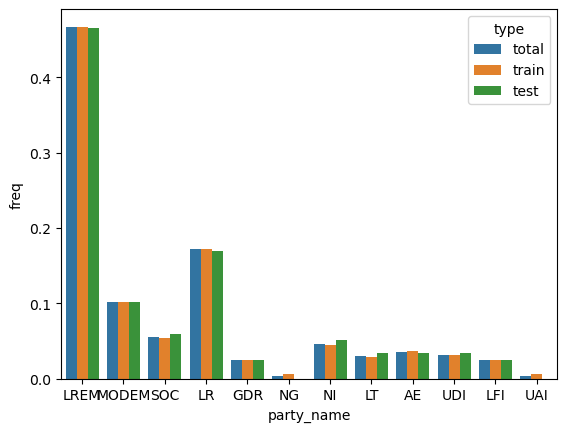

In [27]:
sns.barplot(x="party_name", y="freq", hue="type", data=party_count)

In [7]:
# torch.save(train_tokens_list, "../data/2017-2022/train_data.pt")
# torch.save(test_tokens_list, "../data/2017-2022/test_data.pt")

In [6]:
train_dict = torch.load("../data/2017-2022/train_data.pt")
test_dict = torch.load("../data/2017-2022/test_data.pt")

In [7]:
train_dict.keys()

dict_keys(['tokens', 'masks', 'interventions_masks', 'labels'])

In [9]:
class InterventionsDataset(Dataset):
    def __init__(self, dict_data, max_interventions=100):
        self.labels = dict_data["labels"]
        self.masks = dict_data["masks"][:, :max_interventions, :]
        self.tokens = dict_data["tokens"][:, :max_interventions, :]
        self.interventions_masks = dict_data["interventions_masks"][:, :max_interventions]

    def __len__(self):
        return len(self.labels)

    def get_batch_texts(self, idx):
        return {
            "tokens": self.tokens[idx],
            "masks": self.masks[idx],
            "interventions_masks": self.interventions_masks[idx],
        }

    def get_batch_labels(self, idx):
        return self.labels[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [10]:
train_dataset = InterventionsDataset(train_dict)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = InterventionsDataset(test_dict)
test_dataloader = DataLoader(test_dataset, batch_size=4)

In [11]:
x, y = next(iter(train_dataloader))

In [13]:
input_ids = x["tokens"].to(device=device)
attention_mask = x["masks"].to(device=device)
interventions_masks = x["interventions_masks"].to(device=device)

In [12]:
class BertOnInterventions(nn.Module):
    def __init__(self, bert_model, bert_dim=768):
        super(BertOnInterventions, self).__init__()
        self.bert_model = bert_model
        self.bert_dim = bert_dim
        
    def forward(self, tokens, masks):
        """
        tokens (batch_size, nb_int, nb_tokens)
        masks (batch_size, nb_int, nb_tokens)
        """
        nb_int = tokens.shape[1]
        res = []
        for i in range(nb_int):
            input_ids = tokens[:, i, :]
            attention_mask = masks[:, i, :]
            tmp = self.bert_model(
                input_ids=input_ids, attention_mask=attention_mask
            )["pooler_output"]
            tmp = tmp.unsqueeze(dim=1)
            res.append(tmp)
        pooled_output = torch.cat(res, dim=1)  # (batch_size, nb_int, bert_dim)
        return pooled_output

class InterventionsAttention(nn.Module):
    def __init__(self, bert_dim, num_heads, embed_dim):
        super(InterventionsAttention, self).__init__()
        # Set the parameters
        self.num_attention_heads = num_heads
        self.attention_head_dim = embed_dim // num_heads
        
        # Initialize the linear layers for the multi-head attention
        self.query_linear = nn.Linear(bert_dim, embed_dim)
        self.key_linear = nn.Linear(bert_dim, embed_dim)
        self.value_linear = nn.Linear(bert_dim, embed_dim)

        # Initialize the multi-head attention layer
        self.attention_layer = nn.MultiheadAttention(
            embed_dim=self.embed_dim, num_heads=num_heads, batch_first=True
        )
        
    def forward(self, pooled_output, interventions_masks):
        # Add a zero padding for CLS in attention
        pooled_output_with_cls = F.pad(
            pooled_output, pad=(0, 0, 1, 0), mode="constant", value=0.0
        )  # (batch_size, nb_int + 1, bert_dim)
        
        # Pad the mask as well
        interventions_masks_with_cls = F.pad(interventions_masks, pad=(1, 0), mode="constant", value=1)

        # Split the input tensors into the different attention heads
        query_heads = self.query_linear(
            pooled_output_with_cls
        )  # (batch_size, nb_int + 1, embed_dim)
        key_heads = self.key_linear(pooled_output_with_cls)  # (batch_size, nb_int + 1, embed_dim)
        value_heads = self.value_linear(pooled_output_with_cls)  # (batch_size, embed_dim)

        # Apply the multi-head attention
        attn_output, _ = self.attention_layer(
            query_heads,
            key_heads,
            value_heads,
            key_padding_mask=interventions_masks_with_cls
        )  # (batch_size, embed_dim)

        deputy_repr = attn_output[:, 0, :]  # (batch_size, embed_dim)

        return deputy_repr

In [14]:
camembert_model = CamembertModel.from_pretrained("camembert-base")

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
encoder = BertOnInterventions(camembert_model, bert_dim=768)
encoder.to(device);

BertOnInterventions(
  (bert_model): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0): CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [19]:
with torch.no_grad():
    t = encoder(input_ids, attention_mask)

In [20]:
t

tensor([[[ 0.0638,  0.1658, -0.0528,  ...,  0.0301, -0.0713, -0.0503],
         [ 0.0364,  0.1532, -0.0667,  ...,  0.0101, -0.0971, -0.0164],
         [ 0.0246,  0.1430, -0.0794,  ..., -0.0073, -0.0749, -0.0401],
         ...,
         [-0.0191,  0.1226, -0.0541,  ...,  0.0478, -0.1060,  0.0096],
         [-0.0130,  0.1417, -0.0159,  ...,  0.0538, -0.1065,  0.0467],
         [ 0.0381,  0.1499, -0.0719,  ...,  0.0093, -0.1196, -0.0387]],

        [[ 0.0539,  0.1599, -0.0666,  ...,  0.0035, -0.1023, -0.0491],
         [ 0.0318,  0.1507, -0.0585,  ...,  0.0422, -0.1150, -0.0169],
         [ 0.0139,  0.1357, -0.0343,  ...,  0.0277, -0.0859, -0.0104],
         ...,
         [-0.1143,  0.0934, -0.0202,  ...,  0.0302, -0.0867,  0.0606],
         [-0.0252,  0.1245, -0.0255,  ...,  0.0228, -0.1275,  0.0418],
         [-0.1093,  0.0342,  0.0122,  ...,  0.0848, -0.1800,  0.0435]],

        [[ 0.0439,  0.1139, -0.0494,  ...,  0.0311, -0.0799, -0.0731],
         [ 0.0310,  0.1306, -0.0680,  ...,  0

In [110]:
class SimpleCamembertClassifier(nn.Module):
    def __init__(
        self,
        bert_model,
        num_classes,
        bert_dim=768,
        input_dim=256,
        embed_dim=256,
        input_dim2=256,
        num_heads=8,
        dropout=0.2,
    ):
        super(SimpleCamembertClassifier, self).__init__()

        # Set the parameters
        self.bert_dim = bert_dim
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.input_dim2 = input_dim2
        self.num_attention_heads = num_heads
        self.attention_head_dim = input_dim // num_heads

        # Initialize the BERT model
        self.bert_model = bert_model

        # Initialize the linear layers for the multi-head attention
        self.query_linear = nn.Linear(bert_dim, input_dim)
        self.key_linear = nn.Linear(bert_dim, input_dim)
        self.value_linear = nn.Linear(bert_dim, input_dim)

        # Initialize the multi-head attention layer
        self.attention_layer = nn.MultiheadAttention(
            embed_dim=self.embed_dim, num_heads=num_heads, batch_first=True
        )

        # Initialize the linear layers for the output projection
        self.linear1 = nn.Linear(input_dim, input_dim2)
        self.linear2 = nn.Linear(input_dim, num_classes)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
        # self.mlp = nn.Sequential(
        #     nn.Dropout(dropout),
        #     nn.Linear(input_dim, input_dim2),
        #     nn.ReLU(),
        #     nn.Dropout(dropout),
        #     nn.Linear(input_dim2, num_classes)
        # )

    def forward(self, tokens, masks, interventions_masks):
        """
        tokens (batch_size, nb_int, nb_tokens)
        masks (batch_size, nb_int, nb_tokens)
        interventions_masks (batch_size, nb_int)
        """
        nb_int = tokens.shape[1]

        res = []
        for i in range(nb_int):
            input_ids = tokens[:, i, :]
            attention_mask = masks[:, i, :]
            tmp = self.bert_model(
                input_ids=input_ids, attention_mask=attention_mask
            )["pooler_output"]
            tmp = tmp.unsqueeze(dim=1)
            res.append(tmp)
        pooled_output = torch.cat(res, dim=1)  # (batch_size, nb_int, bert_dim)
        
        # pooled_output = self.bert_model(
        #     input_ids=tokens, attention_mask=masks, return_dict=False
        # )  

        # Add a zero padding for CLS in attention
        pooled_output_with_cls = F.pad(
            pooled_output, pad=(0, 0, 1, 0), mode="constant", value=0.0
        )  # (batch_size, nb_int + 1, bert_dim)

        interventions_masks_with_cls = F.pad(interventions_masks, pad=(1, 0), mode="constant", value=1)

        # Split the input tensors into the different attention heads
        query_heads = self.query_linear(
            pooled_output_with_cls
        )  # (batch_size, nb_int + 1, input_dim)
        key_heads = self.key_linear(pooled_output_with_cls)  # (batch_size, nb_int + 1, input_dim)
        value_heads = self.value_linear(pooled_output_with_cls)  # (batch_size, input_dim)

        # Apply the multi-head attention
        attn_output, _ = self.attention_layer(
            query_heads,
            key_heads,
            value_heads,
            key_padding_mask=interventions_masks_with_cls
        )  # (batch_size, input_dim)

        deputy_repr = attn_output[:, 0, :]  # (batch_size, input_dim)

        dropout_output1 = self.dropout1(deputy_repr)
        linear_output1 = self.relu(self.linear1(dropout_output1))  # (batch_size, input_dim2)
        dropout_output2 = self.dropout2(linear_output1)
        final_layer = self.relu(self.linear2(dropout_output2))  # (batch_size, num_classes)
        
        # final_layer = self.mlp(deputy_repr)

        return final_layer

In [111]:
nb_classes = len(np.unique(train_dict["labels"]))

In [112]:
camembert_model = CamembertModel.from_pretrained("camembert-base")
for param in camembert_model.parameters():
    param.requires_grad = False

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [113]:
classifier = SimpleCamembertClassifier(
    bert_model=camembert_model,
    num_classes=nb_classes,
    bert_dim=768,
    input_dim=64,
    embed_dim=64,
    input_dim2=64,
    num_heads=1,
    dropout=0.2,
)
classifier.to(device);

In [115]:
tokens = x["tokens"].to(device)
masks = x["masks"].to(device)
interventions_masks = x["interventions_masks"].to(device)

In [11]:
train_dataset, val_dataset, test_dataset = get_dataset(
    tokenizer,
    processed_df,
    labels_dict,
    group_var="groupe",
    intervention_var="intervention",
    titre_var="titre_complet",
    profession_var="profession",
    max_len_padding=512,
    max_len_padding_titre=64,
    max_len_padding_profession=16,
    test_frac=0.25,
    val_frac=0.2
)

train_dataloader, val_dataloader, test_dataloader = get_dataloader(
    train_dataset,
    val_dataset,
    test_dataset,
    batch_size=32,
    num_workers=8,
)

bert_model = CamembertModel.from_pretrained("camembert-base")
for p in bert_model.parameters():
    p.requires_grad = False

model = SeanceClassifier(
    bert_model=bert_model,
    num_classes=3,
    intervention_dim=256,
    titre_dim=128,
    profession_dim=64,
    bert_dim=768,
    dropout=0.1
)

In [ ]:
from torch.optim import Adam
from tqdm.autonotebook import tqdm


def train(
    model,
    learning_rate,
    epochs,
    train_dataloader,
    val_dataloader
):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.to(device)
        criterion = criterion.to(device)

    total_acc_trains = []
    total_loss_trains = []
    total_acc_vals = []
    total_loss_vals = []
    
    pbar = tqdm(range(epochs), leave=False)
    for epoch_num in pbar:
        total_acc_train = 0
        total_loss_train = 0

        inner_pbar = tqdm(train_dataloader, leave=False, total=len(train_dataloader), desc="Training")
        for train_input, train_label in train_dataloader:
            train_label = train_label.to(device)
            
            x = {_: {
                "input_ids": train_input[_]["input_ids"].to(device),
                "attention_mask": train_input[_]["attention_mask"].to(device),
            } for _ in ["intervention", "titre", "profession"]}

            output = model(**x)

            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
            
            inner_pbar.update()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():
            inner_pbar.reset(total=len(val_dataloader))
            inner_pbar.set_description("Validation")
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                x = {_: {
                    "input_ids": val_input[_]["input_ids"].to(device),
                    "attention_mask": val_input[_]["attention_mask"].to(device),
                } for _ in ["intervention", "titre", "profession"]}

                output = model(**x)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc
                inner_pbar.update()

        print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_dataloader): .3f} \
            | Train Accuracy: {total_acc_train / len(train_dataloader): .3f} \
            | Val Loss: {total_loss_val / len(val_dataloader): .3f} \
            | Val Accuracy: {total_acc_val / len(val_dataloader): .3f}"
        )
        
        total_acc_trains.append(total_acc_train)
        total_loss_trains.append(total_loss_train)
        total_acc_vals.append(total_acc_val)
        total_loss_vals.append(total_loss_val)

    return {
        "train_loss": total_loss_trains,
        "test_loss": total_loss_vals,
        "train_acc": total_acc_trains,
        "test_acc": total_acc_vals,
    }

In [ ]:
%tensorboard --logdir ../lightning_logs/

In [69]:
train(
    model,
    1e-4,
    10,
    train_dataloader,
    val_dataloader
)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/423 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB (GPU 0; 7.80 GiB total capacity; 6.73 GiB already allocated; 124.31 MiB free; 6.78 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [168]:
classifier = SimpleCamembertClassifier(
    bert_model=camembert_model,
    num_classes=nb_classes,
    bert_dim=768,
    input_dim=64,
    embed_dim=64,
    input_dim2=64,
    num_heads=1,
    dropout=0.2,
)

In [169]:
EPOCHS = 10
LR = 1e-6

results = train(classifier, train_dict, test_dict, LR, EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/89 [00:00<?, ?it/s]

Epochs: 1 | Train Loss:  55.731             | Train Accuracy:  1.750             | Val Loss:  18.784             | Val Accuracy:  0.250


Training:   0%|          | 0/89 [00:00<?, ?it/s]

Epochs: 2 | Train Loss:  55.732             | Train Accuracy:  1.000             | Val Loss:  18.776             | Val Accuracy:  0.500


Training:   0%|          | 0/89 [00:00<?, ?it/s]

Epochs: 3 | Train Loss:  55.688             | Train Accuracy:  0.750             | Val Loss:  18.765             | Val Accuracy:  0.750


Training:   0%|          | 0/89 [00:00<?, ?it/s]

Epochs: 4 | Train Loss:  55.649             | Train Accuracy:  1.000             | Val Loss:  18.758             | Val Accuracy:  0.750


Training:   0%|          | 0/89 [00:00<?, ?it/s]

Epochs: 5 | Train Loss:  55.613             | Train Accuracy:  1.500             | Val Loss:  18.757             | Val Accuracy:  0.250


Training:   0%|          | 0/89 [00:00<?, ?it/s]

Epochs: 6 | Train Loss:  55.605             | Train Accuracy:  1.500             | Val Loss:  18.732             | Val Accuracy:  0.750


Training:   0%|          | 0/89 [00:00<?, ?it/s]

Epochs: 7 | Train Loss:  55.569             | Train Accuracy:  2.250             | Val Loss:  18.735             | Val Accuracy:  0.500


Training:   0%|          | 0/89 [00:00<?, ?it/s]

Epochs: 8 | Train Loss:  55.535             | Train Accuracy:  1.500             | Val Loss:  18.722             | Val Accuracy:  0.500


Training:   0%|          | 0/89 [00:00<?, ?it/s]

Epochs: 9 | Train Loss:  55.515             | Train Accuracy:  1.750             | Val Loss:  18.718             | Val Accuracy:  0.500


Training:   0%|          | 0/89 [00:00<?, ?it/s]

Epochs: 10 | Train Loss:  55.484             | Train Accuracy:  1.250             | Val Loss:  18.704             | Val Accuracy:  0.500


In [170]:
from pathlib import Path
model_path = Path("../models/2017-2022")
model_path.mkdir(parents=True, exist_ok=True)
torch.save(classifier.state_dict(), model_path / "camembert_classifier.pt")

In [171]:
with open(model_path / "camembert_classifier_results.json", "w") as f:
    json.dump(results, f)

In [181]:
res_df = pd.DataFrame(results)
res_df["train_loss"] = res_df["train_loss"] / len(train_dict["labels"])
res_df["train_acc"] = res_df["train_acc"] / len(train_dict["labels"])

res_df["test_loss"] = res_df["test_loss"] / len(test_dict["labels"])
res_df["test_acc"] = res_df["test_acc"] / len(test_dict["labels"])

In [184]:
import matplotlib.pyplot as plt

<AxesSubplot: >

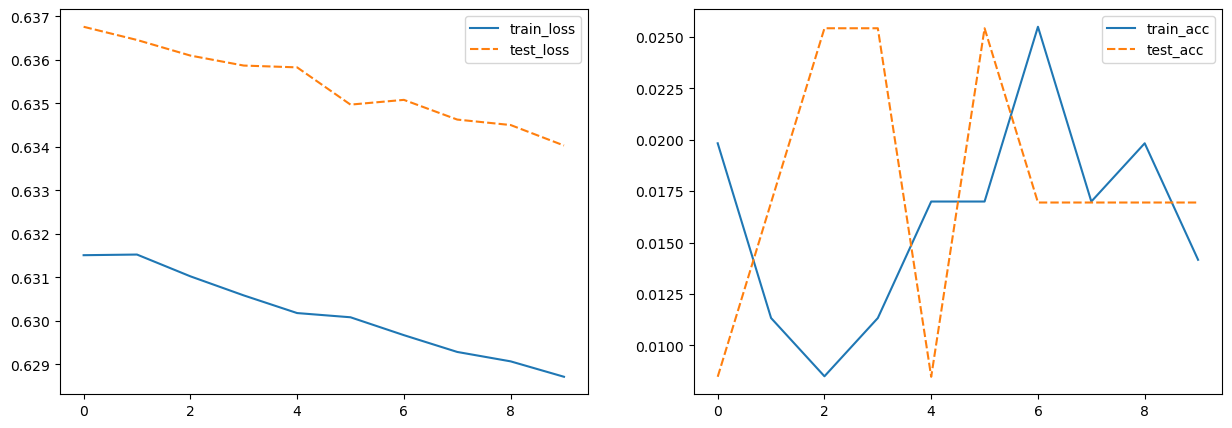

In [185]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(data=res_df[["train_loss", "test_loss"]], ax=axs[0])
sns.lineplot(data=res_df[["train_acc", "test_acc"]], ax=axs[1])

In [177]:
res_df

,train_loss,test_loss,train_acc,test_acc
0,1.889180,0.636762,0.059322,0.008475
1,1.889224,0.636459,0.033898,0.016949
2,1.887727,0.636100,0.025424,0.025424
3,1.886415,0.635870,0.033898,0.025424
4,1.885200,0.635829,0.050847,0.008475
5,1.884910,0.634972,0.050847,0.025424
6,1.883681,0.635082,0.076271,0.016949
7,1.882526,0.634628,0.050847,0.016949
8,1.881879,0.634503,0.059322,0.016949
9,1.880818,0.634032,0.042373,0.016949


In [ ]:
import os
from torch import optim, nn
import pytorch_lightning as pl


# Define the LightningModule
class PLClassifier(pl.LightningModule):
    def __init__(self, classifier):
        super().__init__()
        self.classifier = classifier

    def forward(self, x):
        return self.classifier(x["tokens"], x["masks"], x["interventions_masks"])

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        tokens = x["tokens"]
        masks = x["masks"]
        interventions_masks = x["interventions_masks"]
        
        output = self.classifier(tokens, masks, interventions_masks)
        
        loss = nn.functional.mse_loss(x_hat, x)
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


# init the autoencoder
autoencoder = LitAutoEncoder(encoder, decoder)

In [ ]:

def train(model, train_data, val_data, learning_rate, epochs, batch_size=4):
    train, val = InterventionsDataset(train_data), InterventionsDataset(val_data)

    train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.to(device)
        criterion = criterion.to(device)

    total_acc_trains = []
    total_loss_trains = []
    total_acc_vals = []
    total_loss_vals = []
    
    pbar = tqdm(range(epochs), leave=False)
    for epoch_num in pbar:
        total_acc_train = 0
        total_loss_train = 0

        inner_pbar = tqdm(train_dataloader, leave=False, total=len(train_dataloader), desc="Training")
        for train_input, train_label in train_dataloader:
            train_label = train_label.to(device)
            tokens = train_input["tokens"].to(device)
            masks = train_input["masks"].to(device)
            interventions_masks = train_input["interventions_masks"].to(device)

            output = model(tokens, masks, interventions_masks)

            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
            
            inner_pbar.update()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():
            inner_pbar.reset(total=len(val_dataloader))
            inner_pbar.set_description("Validation")
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                tokens = val_input["tokens"].to(device)
                masks = val_input["masks"].to(device)
                interventions_masks = val_input["interventions_masks"].to(device)

                output = model(tokens, masks, interventions_masks)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc
                inner_pbar.update()

        print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}"
        )

In [ ]:
from pathlib import Path
model_path = Path("../models/2017-2022")
model_path.mkdir(parents=True, exist_ok=True)
torch.save(classifier.state_dict(), model_path / "camembert_classifier.pt")

In [ ]:
torch.save(classifier.state_dict(), model_path / "camembert_classifier.pt")

In [130]:
def evaluate(model, test_data, batch_size=4):

    test = InterventionsDataset(test_data)

    test_dataloader = DataLoader(test, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():
        for test_input, test_label in tqdm(test_dataloader):
            val_label = test_label.to(device)
            tokens = test_input["tokens"].to(device)
            masks = test_input["masks"].to(device)
            interventions_masks = test_input["interventions_masks"].to(device)

            output = model(tokens, masks, interventions_masks)

            acc = (output.argmax(dim=1) == val_label).sum().item()
            total_acc_test += acc

    print(f"Test Accuracy: {total_acc_test / len(test_data): .3f}")

In [131]:
evaluate(classifier, test_dict)

  0%|          | 0/25 [00:00<?, ?it/s]

Test Accuracy:  11.000
